<a href="https://colab.research.google.com/github/econdatatech/GISC420/blob/main/GISC_420_Mini_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### GISC 420 T1 2022
# **Mini Project Part 1**
Corvin Idler

# Challenge

I wanted to create a flow map of NZ exports with a visual appeal similar to e.g. this visualization https://resourcetrade.earth/

I struggled to find the right packages or combination of packages to create interactive flow maps with a reasonable level of control visual details of the flows (e.g. color gradient and shape of the flows). 

This mini project illustrates my journey of trying to solve this problem or finding the right packages for the job.

## ETL
A nessecary "evil" for being able to create a flow map is to first aquire the data to be visualized and wrangle it into the right format.

As a first step we have to import all the stuff we need for the ETL section...

In [ ]:
import re,requests
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
from bs4 import BeautifulSoup

Then we need to define the source URL for the Stats NZ overseas merchandise trade data and define a basic regex to get the file names and URLs for the files we're interested in.

In [ ]:
url = "https://www3.stats.govt.nz/HS10_by_Country/"
r = requests.get(url, allow_redirects=True)

export_files = re.findall(r'(\d{4}_Exports_HS10_by_Country.csv)', str(r.content), re.M) 
export_files = list(dict.fromkeys(export_files))


We then define the columns of interest for the data extract of the CSV files and then nest HTTP GETs (requests.get) inside Pandas read_csv.

We iterate over the URL list from the previous step and concatenate everything to one single dataframe.

It's a bit nerdy code-wise (e.g. the use of BytesIO to turn the results form the requests.get into a "virtual" file) but 
it keeps everything in memory and avoids having to deal with files and folders on a computer. 

**THIS STEP WILL TAKE A COUPLE OF MINUTES AS GOOGLE THROTTLES THEIR INTERNET CONNECTION IN COLAB**

In [ ]:
# Might need this later on.. if I decide to use zip files instead....
#for entry in export_files:
#   ZipFile(BytesIO(requests.get(url+entry, allow_redirects=True).content)).read(export_files)

col_list = ["Month", "Harmonised System Code", "Country", "Exports ($NZD fob)"]
Types = {"Month": str,"Harmonised System Code": str, "Country": str, "Exports ($NZD fob)": str}
df = pd.concat(map(lambda entry: pd.read_csv(BytesIO(requests.get(url+entry, allow_redirects=True).content), 
                                             usecols=col_list, dtype = Types, header=0), export_files))

I decided to initially only worry about yearly figures instead of monthly figures and aggregate all product codes up. 

Basically I reduced the resolution for time and removed the dimension of product categories. 

But that can obviously be change later on in my project.
I sum everything up as part of the reduction in resolution.

In [ ]:
df['Month'] = df['Month'].str[:4]
df. rename(columns = {'Month':'Year'}, inplace = True)
#I'll keep this line around... it allows to reduce HS10 to HSx but for now I get rid of HS completely
#df['Harmonised System Code'] = df['Harmonised System Code'].str.zfill(10).str[:2]

#need to get rid of annyong thousand separators...
df['Exports ($NZD fob)']=df['Exports ($NZD fob)'].str.replace(',', '').astype(int, errors = 'raise')

df=df.groupby(['Year', 'Country']).sum().reset_index()

df.head()

,Year,Country,Exports ($NZD fob)
0,2003,Afghanistan,1185653
1,2003,Albania,604043
2,2003,Algeria,89680192
3,2003,Angola,2964890
4,2003,Antigua and Barbuda,590614


Looking good.... Houston, we have DATA! 

BUT it's not geographic data yet... so I need to find some geographical center data and link it to my trade data so I can visualize flows on a map.

A quick google search shows that google (developers) is your friend. Coordinates are in WGS84.

So I need to do some webscraping and luckily we covered that in the lectures ;-)

A bit of a caveat, that the ISO code for Namibia is NA and read_html thinks that's an actual N/A or NaN.. so I had to set the record straight 
and make it a 'NA' string again.

In [ ]:
# Create an URL object
url = 'https://developers.google.com/public-data/docs/canonical/countries_csv'
# Create object page
page = requests.get(url)

# parser-lxml = Change html to Python friendly format
# Obtain page's information
soup = BeautifulSoup(page.text, 'lxml')

table = soup.find_all('table')
#SUUUUUUPER important to put the fillna('NA') here... because the ISO code of Namibia is NA... and read_html things it's an N/A... no bueno!
geocenter = pd.read_html(str(table))[0].fillna('NA') 

Now we got trade data with country names and gepraphical data with country names and ISO code.

Unfortunately Stats NZ names some of the country in quite a pecular fashion... so it would be good
if we also have a list that matches Stats NZ country names to ISO codes.

Same caveat for Namibia and NA over here again.

Frist step is to left merge the trade data with the country name to ISO code translation table from Stats NZ.

Second step is to left merge the lat. long. info of the geographical centres of each country in there.

We don't do this on the whole data set though.. but only on a list of unique country names from the trade data.

In [ ]:
#Same caveat for Namibia and NA over here... hence the .fillna('NA') at the end.
iso_name=pd.read_excel('https://www.stats.govt.nz/assets/Uploads/Goods-and-services-trade-by-country/Goods-and-services-trade-by-country-year-ended-December-2017/'
                  'Download-data/goods-and-services-trade-by-country-year-ended-december-2017-map-data.xlsx',sheet_name=1).drop(['Country'], axis=1).fillna('NA')

#Add ISO code information from another stats Excel sheet to the Stats NZ specific country names
countries=pd.DataFrame(df['Country'].unique(),columns=['Country']).merge(iso_name, left_on='Country', right_on='country_name', 
                                                                         suffixes=(False, False), how='left')

#Add lat and long info based in ISO code
countries=countries.merge(geocenter, left_on='country_code', right_on='country', suffixes=(False, False), how='left')

Quick "situational awareness check" where we're at now. 

In [ ]:
countries[(countries['latitude'].isnull()) | (countries['latitude']=='NA')]

,Country,country_code,country_name,country,latitude,longitude,name
32,Cape Verde,NaN,NaN,NaN,NaN,NaN,NaN
48,Destination Unknown - EU,NaN,NaN,NaN,NaN,NaN,NaN
134,Netherlands Antilles,NaN,NaN,NaN,NaN,NaN,NaN
139,Niue,NaN,NaN,NaN,NaN,NaN,NaN
149,Passengers' Effects,NaN,NaN,NaN,NaN,NaN,NaN
165,Serbia and Montenegro,NaN,NaN,NaN,NaN,NaN,NaN
167,Ships' Bunkering,NaN,NaN,NaN,NaN,NaN,NaN
168,Ships' Stores,NaN,NaN,NaN,NaN,NaN,NaN
213,Yugoslavia,NaN,NaN,NaN,NaN,NaN,NaN
219,Not Stated,NaN,NaN,NaN,NaN,NaN,NaN


Hm... there are some strange entries here we need to deal with manually...
but Niue should have found it's geographic centre....

So I assume it wasn't in the Stats NZ excelsheet that translates country names to ISO codes...
Maybe we just try matching on country name with the list of greographic centres instead...

The US Minor Outlying Islands are annoying.
Google decided to include them in the list of geographic centres.. but without a lat / long.

So they match but still need to be fixed manually.. I had to add a search term for lat == 'NA' to pick this up :(

In [ ]:
deal_with_me=countries[(countries['latitude'].isnull()) | (countries['latitude']=='NA')]
countries.drop(countries.index[(countries['latitude'].isnull()) | (countries['latitude']=='NA')], inplace=True)
deal_with_me=deal_with_me.drop(geocenter.columns, axis=1).merge(geocenter, left_on='Country', right_on='name',  how='left')
deal_with_me

,Country,country_code,country_name,country,latitude,longitude,name
0,Cape Verde,NaN,NaN,CV,16.002082,-24.013197,Cape Verde
1,Destination Unknown - EU,NaN,NaN,NaN,NaN,NaN,NaN
2,Netherlands Antilles,NaN,NaN,AN,12.226079,-69.060087,Netherlands Antilles
3,Niue,NaN,NaN,NU,-19.054445,-169.867233,Niue
4,Passengers' Effects,NaN,NaN,NaN,NaN,NaN,NaN
5,Serbia and Montenegro,NaN,NaN,NaN,NaN,NaN,NaN
6,Ships' Bunkering,NaN,NaN,NaN,NaN,NaN,NaN
7,Ships' Stores,NaN,NaN,NaN,NaN,NaN,NaN
8,Yugoslavia,NaN,NaN,NaN,NaN,NaN,NaN
9,Not Stated,NaN,NaN,NaN,NaN,NaN,NaN


Cool.... 4 more "winners" to get a lat and long.
I guess the rest needs to be sorted manually....

In [ ]:
#Drop some non-country related Export line items
deal_with_me.drop(deal_with_me.index[deal_with_me['Country'] == 'Passengers\' Effects'], inplace=True)
deal_with_me.drop(deal_with_me.index[deal_with_me['Country'] == 'Ships\' Bunkering'], inplace=True)
deal_with_me.drop(deal_with_me.index[deal_with_me['Country'] == 'Ships\' Stores'], inplace=True)
deal_with_me.drop(deal_with_me.index[deal_with_me['Country'] == 'Not Stated'], inplace=True)

# need to delete these countries as well from the original trade data
df.drop(df.index[df['Country'] == 'Passengers\' Effects'], inplace=True)
df.drop(df.index[df['Country'] == 'Ships\' Bunkering'], inplace=True)
df.drop(df.index[df['Country'] == 'Ships\' Stores'], inplace=True)
df.drop(df.index[df['Country'] == 'Not Stated'], inplace=True)


#Manually fix some countries that might not exist anymore or are a statistical grouping rather than a country.

#https://www.geodatos.net/en/coordinates/united-states-minor-outlying-islands
deal_with_me.loc[deal_with_me['Country']=='United States Minor Outlying Islands',['latitude','longitude']]=(19.282319, 166.647047)
#https://www.geodatos.net/en/coordinates/curacao
deal_with_me.loc[deal_with_me['Country']=='Curacao',['latitude','longitude']]=(12.16957, -68.99002)
#https://www.geodatos.net/en/coordinates/south-sudan
deal_with_me.loc[deal_with_me['Country']=='South Sudan',['latitude','longitude']]=(6.876991, 31.306978)
#https://www.geodatos.net/en/coordinates/serbia
deal_with_me.loc[deal_with_me['Country']=='Yugoslavia',['latitude','longitude']]=(44.016521, 21.005859)
#https://www.geodatos.net/en/coordinates/serbia
deal_with_me.loc[deal_with_me['Country']=='Serbia and Montenegro',['latitude','longitude']]=(44.016521, 21.005859)
#https://www.geodatos.net/en/coordinates/sint-maarten
deal_with_me.loc[deal_with_me['Country']=='St Maarten (Dutch Part)',['latitude','longitude']]=(18.04248, -63.05483)
#https://www.geodatos.net/en/coordinates/palestinian-territory
deal_with_me.loc[deal_with_me['Country']=='Gaza Strip/Palestine/West Bank',['latitude','longitude']]=(31.952162, 35.233154)
#manually selected in google maps... somewhere in the Atlantic Ocean in the bay of biscay
deal_with_me.loc[deal_with_me['Country']=='Destination Unknown - EU',['latitude','longitude']]=(45.90781348707752, -6.777627124289503)

Let's check how we're doing...

In [ ]:
deal_with_me

,Country,country_code,country_name,country,latitude,longitude,name
0,Cape Verde,NaN,NaN,CV,16.002082,-24.013197,Cape Verde
1,Destination Unknown - EU,NaN,NaN,NaN,45.907813,-6.777627,NaN
2,Netherlands Antilles,NaN,NaN,AN,12.226079,-69.060087,Netherlands Antilles
3,Niue,NaN,NaN,NU,-19.054445,-169.867233,Niue
5,Serbia and Montenegro,NaN,NaN,NaN,44.016521,21.005859,NaN
8,Yugoslavia,NaN,NaN,NaN,44.016521,21.005859,NaN
10,Western Sahara,NaN,NaN,EH,24.215527,-12.885834,Western Sahara
11,United States Minor Outlying Islands,UM,United States Minor Outlying Islands,NaN,19.282319,166.647047,NaN
12,Curacao,CW,Curacao,NaN,12.16957,-68.99002,NaN
13,Gaza Strip/Palestine/West Bank,NaN,NaN,NaN,31.952162,35.233154,NaN


Cool... looks like we're ready to join the countries that worked smoothly with those that needed a bit more TLC :)

And while we're at it, we'll 

*  get rid of anything but the essential columns
*  we'll merge the geographical information back with the export values
*  convert things into a GeoPandas frame

Last but not least we'll visualize some trade data from 2018 for a sanity check.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 17.0 MB/s 
     |████████████████████████████████| 6.3 MB 56.3 MB/s 
     |████████████████████████████████| 16.7 MB 62.4 MB/s 


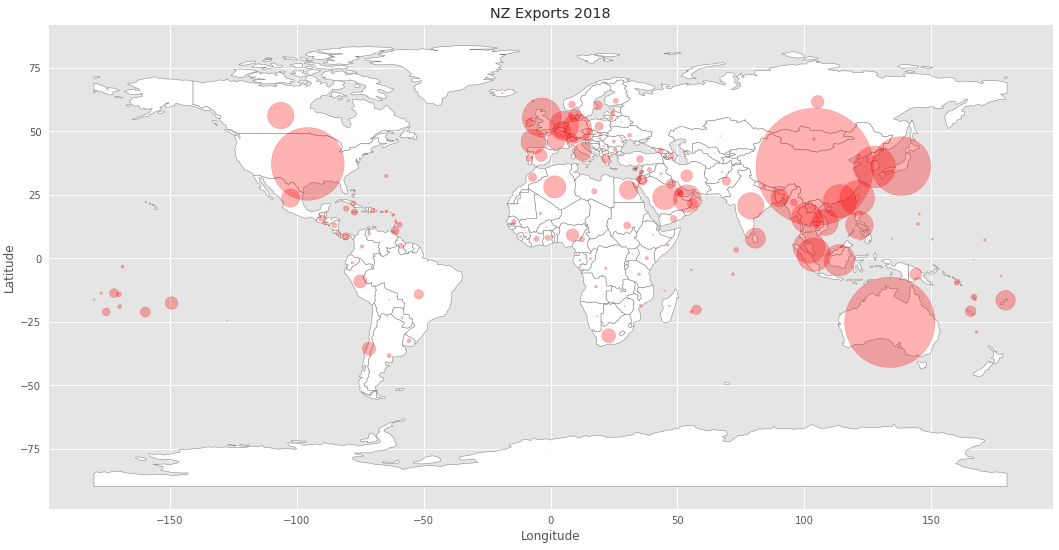

In [ ]:
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

countries=pd.concat([countries,deal_with_me]).drop(['country_code','country_name','country','name'], axis=1)
df=df.merge(countries, left_on='Country', right_on='Country', suffixes=(False, False), how='left')
exports_geo=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude, df.latitude))

#Don't need those two columns anymore
exports_geo.drop('longitude', axis=1,inplace=True)
exports_geo.drop('latitude', axis=1,inplace=True)

exports2018=exports_geo.loc[exports_geo['Year']=='2018',:]

with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10),
               color="white",
               edgecolor = "grey");
    plt.scatter(exports2018.geometry.x,exports2018.geometry.y, s=(exports2018.loc[:,'Exports ($NZD fob)'])/1000000, color="red", alpha=0.3)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("NZ Exports 2018");

Houston... we have geospatial DATA! 
Time to create a flow map!

#Visualization part
First a quick cell to install necessary packages

In [ ]:
!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1"
!pip install mplleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 881 kB 29.6 MB/s 
     |████████████████████████████████| 30.5 MB 164 kB/s 
     |████████████████████████████████| 219 kB 42.2 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=ddf149da4ae04b61c83b0789f4f3f153de97e20500765889aac8beea51700e2a
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-py3-none-any.whl size=28582 sha256=5629a31be16463b5bbf12fb78b89af5d773051cbc5834cb303107be6813f5d8e
  Stored in directory: /root/.cache/pip/wheels/6b/f5/21/cdd12e476182b4b0b98326cdb9efa02ddbd5d87ca5de051c84
Successfully built mplleaflet


Then we try to get some flows going....
First on a simple static basemap

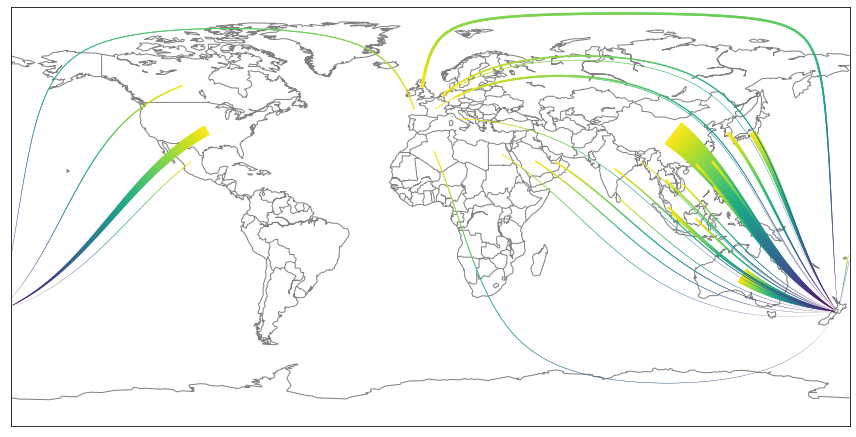

In [ ]:
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
import numpy as np


fig, ax = plt.subplots(figsize=(12,8))

#could try to change center of map to NZ... but then have to change how to draw greatcircle lines as well....
m = Basemap(projection='cyl', lon_0=0, resolution='c')
m.drawcoastlines(color='grey', linewidth=1.0)
m.drawcountries(color='grey', linewidth=1.0)

#Plotting the top 30 export flow in 2018
for index, export in exports_geo[exports_geo['Year']=='2018'].sort_values('Exports ($NZD fob)',ascending = False).head(30).iterrows():  

    a = [[174.885971,-40.900557,export.geometry.x,export.geometry.y]]
    x,y,z,w = a[0]
    line, = m.drawgreatcircle(x,y,z,w,color='r')
    line.remove()
    #Detection logic + remediation for great circles crossing the international dateline
    # taken from https://stackoverflow.com/questions/13888566/python-basemap-drawgreatcircle-function
    p = line.get_path()
    # find the index which crosses the dateline (the delta is large)
    cut_point = np.where(np.abs(np.diff(p.vertices[:, 0])) > 340)[0]
    if cut_point.any():
        cut_point = cut_point[0]

        # create new vertices with a nan inbetween and set those as the path's vertices
        new_verts = np.concatenate(
                                   [p.vertices[:cut_point, :], 
                                    [[np.nan, np.nan]], 
                                    p.vertices[cut_point+1:, :]]
                                   )
        p.codes = None
        p.vertices = new_verts
    mx=p.vertices[:,0]
    my=p.vertices[:,1]

    #taken from https://stackoverflow.com/questions/49078124/basemap-great-circle-longitudinal-wrapping-and-missing-data-issue
    points = np.array([mx, my]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, linewidths=np.linspace(0,(export['Exports ($NZD fob)'])/500000000,len(mx)), cmap='viridis')
    cols = np.linspace(0,1,len(mx))
    lc.set_array(cols)
    line = ax.add_collection(lc)

    #an alternative to line segments could be drawing overlapping circles 
    #c.f. https://stackoverflow.com/questions/19390895/matplotlib-plot-with-variable-line-width

    ax.add_collection(lc)

plt.tight_layout()
plt.show()

Houston, we have a FLOWMAP!

But it's static... and that is boring... 

So I try to draw instead on a dynamic/interactive map using the mplleaflet package, which extracts matplotlib figure components (using https://github.com/mpld3/mplexporter
) and draws them on a leaflet.js map.

I also wanted to have some fun and create a bit of an eye candy. 

So I create my own color map for a blue - red transition... and of course I had to include the NASA Black Marble picture as a tile back ground map... because any flow looks better with a night time map in the background :)

I also had to muck around with transparency so the bigger flows wouldn't cover smaller flow occupying the same real estate. 

I guess I could have sorted things first to determine the drawing order.. but having bigger flows more transparent also looked better in my view.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


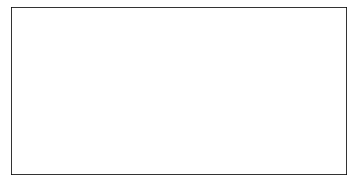

In [ ]:
import mplleaflet

mylist=[]
for index, export in exports_geo[exports_geo['Year']=='2018'].sort_values('Exports ($NZD fob)',ascending = False).head(30).iterrows():  
    m = Basemap()
    a = [[174.885971,-40.900557,export.geometry.x,export.geometry.y]]
    x,y,z,w = a[0]
    line, = m.drawgreatcircle(x,y,z,w,color='r')
    line.remove()
    
    #Detection logic + remediation for great circles crossing the international dateline
    # taken from https://stackoverflow.com/questions/13888566/python-basemap-drawgreatcircle-function
    #can probably be optimized by porting over R code to python:
    #https://gis.stackexchange.com/questions/122494/how-to-prevent-cross-world-lines-in-ggplot-world-map
    #http://web.stanford.edu/~cengel/cgi-bin/anthrospace/great-circles-on-a-recentered-worldmap-in-ggplot
    
    p = line.get_path()
    # find the index which crosses the dateline (the delta is large)
    cut_point = np.where(np.abs(np.diff(p.vertices[:, 0])) > 180)[0]
    if cut_point.any():
        cut_point = cut_point[0]

        # create new vertices with a nan inbetween and set those as the path's vertices
        new_verts = np.concatenate(
                                   [p.vertices[:cut_point, :], 
                                    [[np.nan, np.nan]], 
                                    p.vertices[cut_point+1:, :]]
                                   )
        p.codes = None
        p.vertices = new_verts
    mx=p.vertices[:,0]
    my=p.vertices[:,1]
    #taken from https://stackoverflow.com/questions/72256402/how-can-i-plot-a-single-line-that-changes-its-color-per-y-value-interval-or-labe
    r = np.linspace(0,1,len(mx)) # red
    b = np.linspace(1,0,len(mx)) # blue
    g = np.linspace(0,0,len(mx)) # blue
    rgb = list(zip(r,g,b)) 
    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be numlines x points per line x 2 (x and y)
    points = np.array([mx, my]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, linewidths=np.linspace(0,(export['Exports ($NZD fob)'])/500000000,len(mx)), colors=rgb, alpha=0.55/np.sqrt(export['Exports ($NZD fob)']/500000000))

    mylist.append(lc)
 
fig = plt.figure(figsize=(12,16))


for lc in mylist:
  ax=fig.add_subplot()
  ax.add_collection(lc)

mplleaflet.display(fig=ax.figure,tiles=('https://gibs.earthdata.nasa.gov/wmts/epsg3857/best/VIIRS_CityLights_2012/default//GoogleMapsCompatible_Level8/{z}/{y}/{x}.jpg','NASA Earthdata'))



Houston we have an "interactive"/"dynamic" FLOWMAP! Well... it's actually just a slippy map so far, but I'm sort of happy that I came this far. That said, we should be honest as well about the limitations.


*   when you zoom in too much you can see the individual line segments. That is expected.. but not pretty.
*   There is no mouse over functionality to show some information about a particular flow.. and given that each flow is a bunch of line segments in a line collection, I don't know how easily I could add that.
*   There are some issues with the projection (some of the great circles are cut off). Whenever I wanted to tinker around with the projection of the mplleaflet map, things fell apart real quick (e.g. nothing was rendered)
*   I'm annoyed that the map wraps around and is replicated over and over. I couldn't get the/a nowrap flag working. This also leads to flows starting from NZ on the right as well as NZ on the left. Maybe this can be fixed by centering the map around NZ. 

I feel like instead of perfectioning the above map I'd rather spent some time exploring other options.
Maybe one day when I have too much time I'll try to animate the map with flows over different months or years. Like https://ruaridhw.github.io/london-tube/VisualisingData.html


# Exit
Last step is to save my geo data frame. I'll place it manually on github (https://github.com/econdatatech/GISC420/blob/main/nzexports_geo.parquet?raw=true) so my next notebook doesn't have to go through the whole data wrangling again.

In [ ]:
exports_geo.to_parquet('nzexports_geo.parquet')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.
